Oh Boy, maybe I can understand sklearn stuff. 

From my boy OLEKSII ZHUKOV @<https://www.kaggle.com/code/zhukovoleksiy/house-prices-detailed-top-5-solution>
Affectionately referred to as 'Homeboy' in the remainder of this notebook

**Install Kaleido package** to transform plotly charts to svg and png format, so they are visible on GitHub
*!pip install -U kaleido*

In [1]:
# Essentials
import numpy as np
import pandas as pd

# Visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Models
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor

# Useful line of code to set the display option so we could see all the columns in pd dataframe
pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# Load train dataset and make a copy of it
train = pd.read_csv('../data/train.csv')
df_train = train.copy()

# Load test dataset
test = pd.read_csv('../data/test.csv')

## Check Dataset

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.shape

(1460, 81)

Show null features

In [5]:
df_train.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

Print the number of object type features

In [6]:
object_features = []
for column in df_train.columns:
    if df_train[column].dtype == 'object':
        object_features.append(column)

print(f'Object features: {object_features} \n\nNumber of object features: {len(object_features)}')

Object features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] 

Number of object features: 43


## Exploratory Data Analysis

*check the Sale Price distribution*

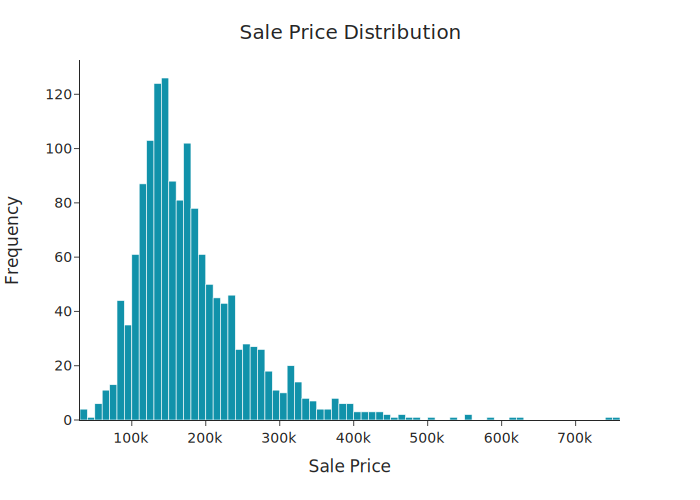

In [7]:
# Create figure
fig = px.histogram(x = df_train['SalePrice'],
                   template='simple_white',
                   color_discrete_sequence = ['#1192AA'])



# Set Title and x/y axis labels
fig.update_layout(
    xaxis_title="Sale Price",
    yaxis_title="Frequency",
    showlegend = False,
    font = dict(
            size = 14
            ),    
    title={
        'text': "Sale Price Distribution",
        'y':0.95,
        'x':0.5
        }
    )

# Display
fig.show("svg") # for GitHub version

The distribution is right skewed. Now check skewness and kurtosis of this distribution. 

In [8]:
print(f"Skewness: {df_train['SalePrice'].skew()}")
print(f"Kurtosis: {df_train['SalePrice'].kurt()}")

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


## Plot function to check distribution plots of data columns.

In [9]:
# Plot function
def plot_column_distribution(df, column_name):
    """plot a distribution of certain column with [column_name] from [df] dataframe"""

    # Create figure
    fig = px.histogram(df[column_name],
                       template = 'simple_white',
                       color_discrete_sequence = ['#1192AA'])

    # Set Title and x/y axis labels
    fig.update_layout(
        xaxis_title="Value",
        yaxis_title="Frequency",
        showlegend = False,
        font = dict(
                size = 14
                ),    
        title={
            'text': column_name,
            'y':0.95,
            'x':0.5
            }
        )

    # Display
    fig.show()

Next is code to call the plot function for almost all the columns

In [11]:
#for column in df_train.columns[1:-2]:
#    plot_column_distribution(df_train, column)

Corrplot of all numeric features

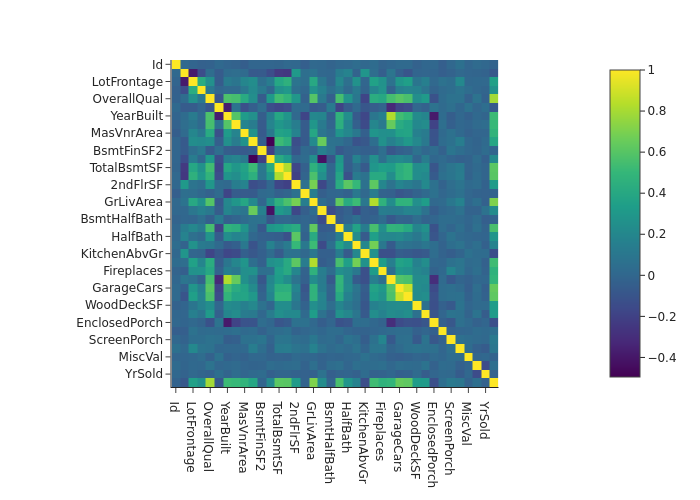

In [10]:
numeric_dtypes = ['int64', 'float64']
numeric = []
for i in df_train.columns:
    if df_train[i].dtype in numeric_dtypes:
        numeric.append(i)


fig = px.imshow(df_train.loc[:, numeric].corr(), template='simple_white')

# Display
#fig.show() # for Kaggle version
fig.show("png") # for GitHub version

Comparing SalePrice relation to some of the features in the dataset:

In [11]:
# Select features
features = ['OverallQual', 'GrLivArea', 'GarageArea', 'GarageCars', 'TotalBsmtSF']

for feature in features:
    # Create figure 
    fig = px.scatter(df_train, feature, 'SalePrice', 
                     trendline="ols", trendline_scope="overall", trendline_color_override="red",
                     template = 'simple_white',
                     color_discrete_sequence = ['#1192AA'])
    
    # Set Title and x/y axis labels
    fig.update_layout(
        xaxis_title="Value",
        yaxis_title="Frequency",
        showlegend = False,
        font = dict(
                size = 14
                ),    
        title={
            'text': feature,
            'y':0.95,
            'x':0.5
            }
        )
    
    # Display
    #fig.show() # for Kaggle version
    fig.show("png") # for GitHub version

ModuleNotFoundError: No module named 'statsmodels'

## Data Cleaning

In [14]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Now we *Normalize SalePrice*

In [15]:
#Log transform SalePrice
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

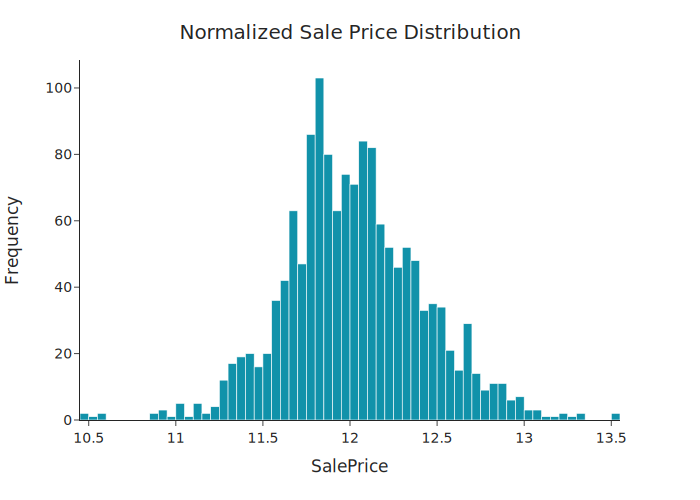

In [16]:
# Create figure
fig = px.histogram(x = df_train['SalePrice'],
                   template = 'simple_white',
                   color_discrete_sequence = ['#1192AA'])

# Set Title and x/y axis labels
fig.update_layout(xaxis_title="SalePrice",
                  yaxis_title="Frequency",
                  showlegend = False,
                  font = dict(size = 14),
                  title={'text': "Normalized Sale Price Distribution",
                         'y':0.95,
                         'x':0.5
                         }
)

# Display
fig.show("svg")

### Create function for cleaning dataset:

In [17]:
def clean(X):
    
    # Replace some corrupted data
    X["Exterior2nd"] = X["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    X["GarageYrBlt"] = X["GarageYrBlt"].where(X.GarageYrBlt <= 2010, X.YearBuilt)
    
    # Change data types in numerical features that should be categorical
    X['MSSubClass'] = X['MSSubClass'].apply(str)
    X['YrSold'] = X['YrSold'].astype(str)
    X['MoSold'] = X['MoSold'].astype(str)
    
    # Handle missing
    X['Functional'] = X['Functional'].fillna('Typ') 
    X['Electrical'] = X['Electrical'].fillna("SBrkr") 
    X['KitchenQual'] = X['KitchenQual'].fillna("TA") 
    X["PoolQC"] = X["PoolQC"].fillna("None")
    X['Exterior1st'] = X['Exterior1st'].fillna(X['Exterior1st'].mode()[0]) 
    X['Exterior2nd'] = X['Exterior2nd'].fillna(X['Exterior2nd'].mode()[0])
    X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])
    X["PoolQC"] = X["PoolQC"].fillna("None")
    
    # Replacing the missing values with 0, since no garage = no cars in garage
    for column in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        X[column] = X[column].fillna(0)
        
    # Replacing the missing values with None
    for column in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        X[column] = X[column].fillna('None')
        
    # NaN values for these categorical basement features, means there's no basement
    for column in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        X[column] = X[column].fillna('None')
        
    # Replace left features missing values with None
    objects = []
    for i in X.columns:
        if X[i].dtype == object:
            objects.append(i)
    X.update(X[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in X.columns:
        if X[i].dtype in numeric_dtypes:
            numeric.append(i)
    X.update(X[numeric].fillna(0))

Create function for normalazing numerical features:

In [18]:
def log_transform(X):

    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in X.columns:
        if X[i].dtype in numeric_dtypes:
            numeric.append(i)

    # Compute skewness
    skewed_features = X[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
    skewed_features = skewed_features[skewed_features > 0.5]
    skewed_features = skewed_features.index

    # Transform skewed features
    for i in skewed_features:
        X[i] = np.log1p(X[i])

Use those function on train dataset and check what we have

In [19]:
clean(df_train)
log_transform(df_train)
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,1.791759,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,Gd,TA,PConc,Gd,TA,No,GLQ,6.561031,Unf,0.0,5.017280,6.753438,GasA,Ex,Y,SBrkr,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,2,0.693147,3,0.693147,Gd,2.197225,Typ,0.000000,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,2.197225,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,6.886532,Unf,0.0,5.652489,7.141245,GasA,Ex,Y,SBrkr,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,2,0.000000,3,0.693147,TA,1.945910,Typ,0.693147,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,None,None,None,0.0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,1.791759,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,Gd,TA,PConc,Gd,TA,Mn,GLQ,6.188264,Unf,0.0,6.075346,6.825460,GasA,Ex,Y,SBrkr,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,2,0.693147,3,0.693147,Gd,1.945910,Typ,0.693147,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,None,None,None,0.0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1.791759,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,5.379897,Unf,0.0,6.293419,6.629363,GasA,Gd,Y,SBrkr,6.869014,6.629363,0.0,7.448916,0.693147,0.000000,1,0.000000,3,0.693147,Gd,2.079442,Typ,0.693147,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0.000000,3.583519,5.609472,0.0,0.0,0.0,None,None,None,0.0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,1.791759,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.860786,Gd,TA,PConc,Gd,TA,Av,GLQ,6.486161,Unf,0.0,6.196444,7.044033,GasA,Ex,Y,SBrkr,7.044033,6.960348,0.0,7.695758,0.693147,0.000000,2,0.693147,4,0.693147,Gd,2.302585,Typ,0.693147,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,5.262690,4.442651,0.000000,0.0,0.0,0.0,None,None,None,0.0,12,2008,WD,Normal,12.429220


Edit: Don't actually do this.
Drop ID coloumn

In [20]:
#df_train = df_train.drop('Id', axis=1)
#df_train.head(3)

Check if we have any missing values:

In [21]:
df_train.isnull().sum().sum()

0

### Feature Engineering

In [22]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,1.791759,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,Gd,TA,PConc,Gd,TA,No,GLQ,6.561031,Unf,0.0,5.017280,6.753438,GasA,Ex,Y,SBrkr,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,2,0.693147,3,0.693147,Gd,2.197225,Typ,0.000000,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,2.197225,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,6.886532,Unf,0.0,5.652489,7.141245,GasA,Ex,Y,SBrkr,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,2,0.000000,3,0.693147,TA,1.945910,Typ,0.693147,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,None,None,None,0.0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,1.791759,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,Gd,TA,PConc,Gd,TA,Mn,GLQ,6.188264,Unf,0.0,6.075346,6.825460,GasA,Ex,Y,SBrkr,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,2,0.693147,3,0.693147,Gd,1.945910,Typ,0.693147,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,None,None,None,0.0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1.791759,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,5.379897,Unf,0.0,6.293419,6.629363,GasA,Gd,Y,SBrkr,6.869014,6.629363,0.0,7.448916,0.693147,0.000000,1,0.000000,3,0.693147,Gd,2.079442,Typ,0.693147,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0.000000,3.583519,5.609472,0.0,0.0,0.0,None,None,None,0.0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,1.791759,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.860786,Gd,TA,PConc,Gd,TA,Av,GLQ,6.486161,Unf,0.0,6.196444,7.044033,GasA,Ex,Y,SBrkr,7.044033,6.960348,0.0,7.695758,0.693147,0.000000,2,0.693147,4,0.693147,Gd,2.302585,Typ,0.693147,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,5.262690,4.442651,0.000000,0.0,0.0,0.0,None,None,None,0.0,12,2008,WD,Normal,12.429220


Homeboy says that he is using Linear models, such as Lasso Regression and Ridge Regression. Linear models assume tht there is a linear relationship between the input features and the output variable. If the true relationship is more complex than this, a linear model may not be able to capture all of the nuances of the data. Therefore, by using feature engineering, and manualy creating new features, linear models can often be improved to capture more complex patterms in the data. 

In [23]:
def drop_uninformative(x):
    x.drop(['Id','Utilities', 'Street', 'PoolQC', 'MiscFeature', 'MiscVal', 'YearRemodAdd'], axis=1, inplace = True)

In [24]:
def counts(X):
    X['HasWoodDeck'] = X['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasOpenPorch'] = X['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasEnclosedPorch'] = X['EnclosedPorch'].apply(lambda x: 1 if x > 0 else 0)
    X['Has3SsnPorch'] = X['3SsnPorch'].apply(lambda x: 1 if x > 0 else 0)
    X['HasScreenPorch'] = X['ScreenPorch'].apply(lambda x: 1 if x > 0 else 0)
    X['HasPool'] = X['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    X['Has2ndFloor'] = X['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasGarage'] = X['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    X['HasBsmt'] = X['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasFireplace'] = X['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [25]:
def encode_features(X):
    return pd.get_dummies(X).reset_index(drop=True)

In [26]:
def math_transform(X):
    X["SqFtPerRoom"] = X["GrLivArea"] / (X["TotRmsAbvGrd"] + X["FullBath"] + X["HalfBath"] + X["KitchenAbvGr"])
    X['TotalSqrFootage'] = (X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['1stFlrSF'] + X['2ndFlrSF'])
    X['TotalBathrooms'] = (X['FullBath'] + (0.5 * X['HalfBath']) + X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))
    X['TotalPorchSF'] = (X['OpenPorchSF'] + X['3SsnPorch'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF'])
    X['TotalHomeQuality'] = (X['OverallQual'] + X['OverallCond'])

Apply all functions to the train dataset:

In [27]:
drop_uninformative(df_train)
counts(df_train)
math_transform(df_train)
df_train = encode_features(df_train)

# Check dataset
df_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,SalePrice,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,HasPool,Has2ndFloor,HasGarage,HasBsmt,HasFireplace,SqFtPerRoom,TotalSqrFootage,TotalBathrooms,TotalPorchSF,TotalHomeQuality,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,F

## Data Preprocessing

Create function that will apply all data preprocessing functions to the dataset:

In [28]:
def data_preprocessing(X):
    
    # From Data Cleaning section
    clean(X)
    log_transform(X)
    
    # From Feature Engineering section
    drop_uninformative(X)
    counts(X)
    math_transform(X)
    X = encode_features(X)
    return X

Merge train and test datasets to preprocess them, also set target y_tain:

In [29]:
# Save shapes 
ntrain = train.shape[0]
ntest = test.shape[0]

# Here we take log transformed values from df_train to set a train target
y = df_train.SalePrice.values 

# Create new dataset to preprocess data: 
df_new = pd.concat((train, test)).reset_index(drop=True)
df_new.drop(['SalePrice'], axis=1, inplace=True)

Call data_preprocessing and check out data:

In [30]:
all_data = data_preprocessing(df_new)
all_data.tail()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,HasPool,Has2ndFloor,HasGarage,HasBsmt,HasFireplace,SqFtPerRoom,TotalSqrFootage,TotalBathrooms,TotalPorchSF,TotalHomeQuality,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_

Split all preprocessed data to train and test. Check shapes (train and test must have the same number of columns, train and y_train must have the same number of rows):

In [31]:
train = all_data[:ntrain]
test = all_data[ntrain:]
print(f"train shape: {train.shape}\ny_train shape: {y.shape}\ntest shape: {test.shape}")

train shape: (1460, 333)
y_train shape: (1460,)
test shape: (1459, 333)


# Model Building

Homeboy says:
The main idea was to sue Lasso and Ridge regressions, because I (homeboy) used one-hot encoding technics in feature engineering part, and those models work better with big amount of features, as they help to prevent overfitting and improce the model's generalization performance. 

However, its important (homeboy continues here. beautiful instruction really) to note that Lasso and Ridge regressions may not always be the best performing models for a given dataset. Therefore, I will also be testing other regression models such as XGBoost Regressor, Support Vector Regressor, and LGBMRegressor. (I, anomalytheorem, think this is sensible. I like this) These models are known to perform well on a wide range of datasets, and I'm (homeboy) interested in seeing how they compare to the Lasso and Ridge regressions on the House Prices dataset. (I, anaomlytheroem, am also interested in this comparison. I'm glad homeboy is walking me through this.)

Setup cross validation folds:

In [32]:
kf = KFold(n_splits=12, shuffle=True, random_state=11)

Define error metrics:

In [33]:
# Root Mean Squared Error
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Cross Validation of the Root Mean Square Error Baby
def cv_rmse(model, X=train):
    return np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))

Set up models:

In [34]:
# Set up Parameters 
ridge_alphas = [15.2, 15.35, 15.4, 15.45, 15.5, 15.6]
lasso_alphas = [0.0005, 0.00055, 0.0006, 0.00065, 0.0007]

svr_grid = {'C': [20, 22], 'epsilon':[0.008, 0.009], 'gamma': [0.001, 0.002, 0.0025]}

# Ridge Regression
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas=ridge_alphas, cv=kf))

# Lasso Regression
lasso = make_pipeline(RobustScaler(),
                      LassoCV(alphas=lasso_alphas,
                              random_state=11, cv=kf))

# Support Vector Regression
svr = make_pipeline(RobustScaler(),
                    GridSearchCV(SVR(),svr_grid, cv=kf))

# Light Gradient Boosting Regression
lightgbm = LGBMRegressor(n_estimators=6999,
                         learning_rate=0.01, 
                         num_leaves=6,
                         bagging_seed=8,
                         feature_fraction_seed=8,
                         objective='mse',
                         random_state=11,
                         )

# XGBoost Regression
xgboost = XGBRegressor(n_estimators=2000,
                       learning_rate=0.03,
                       max_depth=4,
                       subsample=0.72,
                       colsample_bytree=0.41,
                       random_state = 11)

Check scores:

In [35]:
score_lightgbm = cv_rmse(lightgbm)
print(f"lightgbm: {score_lightgbm.mean()}")

lightgbm: 0.13272300054320899


In [36]:
score_xgboost = cv_rmse(xgboost)
print(f"xgboost: {score_xgboost.mean()}")

xgboost: 0.12575723320483312


In [37]:
score_ridge = cv_rmse(ridge)
print(f"ridge: {score_ridge.mean()}")

ridge: 0.12610381077387986


In [38]:
score_lasso = cv_rmse(lasso)
print(f"lasso: {score_lasso.mean()}")

lasso: 0.12254873260733884


In [39]:
# This one takes lots of computring. So I have to ignore this.
score_svr = cv_rmse(svr)
print(f"svr: {score_svr.mean()}")

svr: 0.12356430347998708


In [40]:
scores = {'lightgbm': score_lightgbm,
          'xgboost': score_xgboost,
          'ridge': score_ridge,
          'lasso': score_lasso,
          'svr': score_svr}
# Excluding 'svr': score_svr due to computation time. <3

Homeboy continues after charitably showing me how to get these scores...

In addition, I am going to train a meta model StackingCVRegressor optimizer using CatBoostRegressor. Meta-learning is a type of machine learning that involves learning from other machine learning models. In the contaxt of regression models, meta-learning can be used to combin the predixtions of multiple bse models to create a more accurate overall prediction. 

An explosion of thoughts in my mind. Thank you Homeboy.

In [41]:
# Homeboy had iterations at 6,000. But I'm just learning here and I think less will take less time <3
meta_model = CatBoostRegressor(iterations = 6000,
                               learning_rate = 0.005,
                               depth = 4,
                               l2_leaf_reg = 1,
                               eval_metric = 'RMSE',
                               random_seed = 11,
                               logging_level = 'Silent')

stacking_model = StackingCVRegressor(regressors=(lasso, ridge, xgboost, lightgbm, svr),
                                     meta_regressor=meta_model,
                                     use_features_in_secondary=True)

This code could be used to check cross validation score fo stacking model, but it will take a lot of time to run it. 
Since homeboy did not warn us about the 12 min computation time for svr, I'm guessing this one is like 30 plus. I aint about that life. 

score_stacking_model = cv_rmse(stacking_model)
scores['stacking'] = score_stacking_model
print(f"svr: {score_stacking_model.mean()}")

Fite the models:

In [42]:
lightgbm_fit = lightgbm.fit(train, y)

xgboost_fit = xgboost.fit(train, y)

ridge_fit = ridge.fit(train, y)

lasso_fit = lasso.fit(train, y)

svr_fit = svr.fit(train, y)

stacking_model_fit = stacking_model.fit(np.array(train), np.array(y))

## Blend and Predict

Define function: Homeboy uses some values. It would be cool to switch em up.

In [49]:
def blend_predeictions(X):
    return ((0.1 * lightgbm_fit.predict(X)) + \
            (0.1 * xgboost_fit.predict(X)) + \
            (0.2 * ridge_fit.predict(X)) + \
            (0.2 * lasso_fit.predict(X)) + \
            (0.15 * svr_fit.predict(X)) + \
            (0.25 * stacking_model_fit.predict(np.array(X))))

Check blended score:
*yikes, fingers crossed*

In [50]:
blended_score = rmse(y, blend_predeictions(train))
scores['blended'] = blended_score
print(f"Blended score: {blended_score}")

Blended score: 0.06762862585041737


Plot all scores:

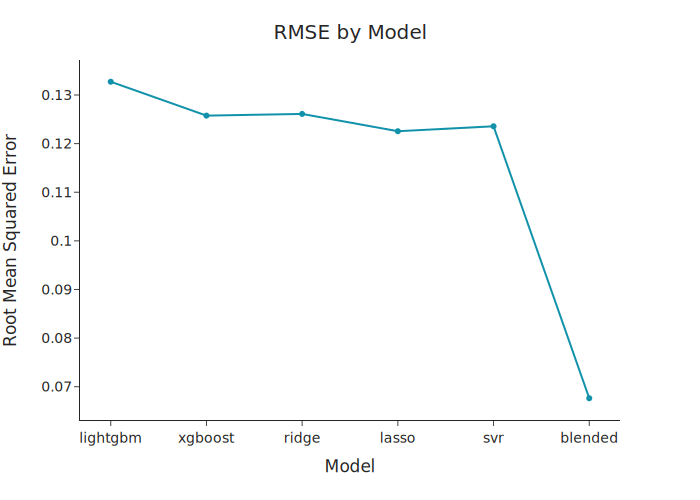

In [51]:
# Create figure
fig = px.line(x=list(scores.keys()), y=[score.mean() for score in scores.values()],
              markers=True, color_discrete_sequence = ['#1192AA'], template = 'simple_white')

# Set Title and x/y axis labels
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Root Mean Squared Error",
    showlegend = False,
    font = dict(
            size = 14
    ),
    title={
        'text': "RMSE by Model",
        'y':0.95,
        'x':0.5
    }
    )

# Display
fig.show("svg")

Submission:

In [55]:
submission = pd.read_csv("../data/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_predeictions(test)))

q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

submission.to_csv("../data/submission.csv", index=False)

Disply that delicious submission

In [56]:
submission_reader = pd.read_csv("../data/submission.csv")
submission_reader.head()

,Id,SalePrice
0,1461,122671.0
1,1462,163033.0
2,1463,184005.0
3,1464,199360.0
4,1465,193130.0


Thanks be to Homeboy. We will always cherish thee. 

released under the Apache 2.0 open source license @Oleksiy-Zhukov